In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input,Conv1D,MaxPooling1D,GRU,LSTM,Bidirectional,Dense,Dropout,Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop


2023-04-10 03:51:22.162236: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 03:51:22.209771: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 03:51:22.210729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 03:51:23.292917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df=pd.read_csv('../PRSA_data_2010.1.1-2014.12.31.csv')
df=df.iloc[:,1:-7]
df["Date"] = pd.to_datetime(df["year"].apply(str) + "/" + df["month"].apply(str) + "/" + df["day"].apply(str)+ " " + df["hour"].apply(str)+ ":" +"00")
df=df.drop(['year','month','day','hour'],axis=1)
df=df.dropna()
df=df.rename(columns={'Date':'DATE','pm2.5':'PM'})
df=df.set_index('DATE')
df

,PM
DATE,
2010-01-02 00:00:00,129.0
2010-01-02 01:00:00,148.0
2010-01-02 02:00:00,159.0
2010-01-02 03:00:00,181.0
2010-01-02 04:00:00,138.0
...,...
2014-12-31 19:00:00,8.0
2014-12-31 20:00:00,10.0
2014-12-31 21:00:00,10.0


In [3]:
df.describe()

,PM
count,41757.000000
mean,98.613215
std,92.050387
min,0.000000
25%,29.000000
50%,72.000000
75%,137.000000
max,994.000000


In [4]:
data=df

In [5]:
# Scale data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [6]:
data

array([[0.12977867],
       [0.14889336],
       [0.15995976],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]])

In [7]:
# Split data into training and testing sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

In [8]:
print(train_size,test_size)
print(train_data,test_data)
print(len(train_data),len(test_data))

33405 8352
[[0.12977867]
 [0.14889336]
 [0.15995976]
 ...
 [0.30080483]
 [0.25150905]
 [0.15995976]] [[0.12474849]
 [0.12374245]
 [0.04929577]
 ...
 [0.01006036]
 [0.00804829]
 [0.01207243]]
33405 8352


In [9]:
# Convert data into time series dataset
def create_dataset(dataset, look_back=24):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(Y)

In [10]:
look_back = 24
train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

In [11]:
#print(train_X,train_Y)
#print(test_X,test_Y)
print(train_Y,test_Y)

[0.09054326 0.06338028 0.06539235 ... 0.30080483 0.25150905 0.15995976] [0.17303823 0.21428571 0.1971831  ... 0.01006036 0.00804829 0.01207243]


In [12]:
len(test_Y),len(train_Y)

(8328, 33381)

In [13]:
len(test_X),len(train_X)

(8328, 33381)

In [14]:
test_X.shape

(8328, 24)

In [15]:
print(train_X,test_X)

[[0.12977867 0.14889336 0.15995976 ... 0.16498994 0.15694165 0.12676056]
 [0.14889336 0.15995976 0.18209256 ... 0.15694165 0.12676056 0.09054326]
 [0.15995976 0.18209256 0.138833   ... 0.12676056 0.09054326 0.06338028]
 ...
 [0.05734406 0.05734406 0.07545272 ... 0.13179074 0.17806841 0.28873239]
 [0.05734406 0.07545272 0.09657948 ... 0.17806841 0.28873239 0.30080483]
 [0.07545272 0.09657948 0.11066398 ... 0.28873239 0.30080483 0.25150905]] [[0.12474849 0.12374245 0.04929577 ... 0.12273642 0.12374245 0.12273642]
 [0.12374245 0.04929577 0.0362173  ... 0.12374245 0.12273642 0.17303823]
 [0.04929577 0.0362173  0.05935614 ... 0.12273642 0.17303823 0.21428571]
 ...
 [0.02012072 0.00804829 0.01609658 ... 0.01006036 0.00804829 0.01006036]
 [0.00804829 0.01609658 0.01006036 ... 0.00804829 0.01006036 0.01006036]
 [0.01609658 0.01006036 0.0110664  ... 0.01006036 0.01006036 0.00804829]]


In [16]:
train_X = np.expand_dims(train_X, axis=2)
test_X = np.expand_dims(test_X, axis=2)

In [17]:
print(train_X,test_X)

[[[0.12977867]
  [0.14889336]
  [0.15995976]
  ...
  [0.16498994]
  [0.15694165]
  [0.12676056]]

 [[0.14889336]
  [0.15995976]
  [0.18209256]
  ...
  [0.15694165]
  [0.12676056]
  [0.09054326]]

 [[0.15995976]
  [0.18209256]
  [0.138833  ]
  ...
  [0.12676056]
  [0.09054326]
  [0.06338028]]

 ...

 [[0.05734406]
  [0.05734406]
  [0.07545272]
  ...
  [0.13179074]
  [0.17806841]
  [0.28873239]]

 [[0.05734406]
  [0.07545272]
  [0.09657948]
  ...
  [0.17806841]
  [0.28873239]
  [0.30080483]]

 [[0.07545272]
  [0.09657948]
  [0.11066398]
  ...
  [0.28873239]
  [0.30080483]
  [0.25150905]]] [[[0.12474849]
  [0.12374245]
  [0.04929577]
  ...
  [0.12273642]
  [0.12374245]
  [0.12273642]]

 [[0.12374245]
  [0.04929577]
  [0.0362173 ]
  ...
  [0.12374245]
  [0.12273642]
  [0.17303823]]

 [[0.04929577]
  [0.0362173 ]
  [0.05935614]
  ...
  [0.12273642]
  [0.17303823]
  [0.21428571]]

 ...

 [[0.02012072]
  [0.00804829]
  [0.01609658]
  ...
  [0.01006036]
  [0.00804829]
  [0.01006036]]

 [[0.008

In [18]:
input_layer = Input(shape=(look_back, 1))
input_layer

<KerasTensor: shape=(None, 24, 1) dtype=float32 (created by layer 'input_1')>

In [19]:
LSTM=LSTM(128, activation='relu',return_sequences=False, bias_regularizer=l1(0.4))(input_layer)
drop=Dropout(0.2)(LSTM)
den=Dense(1)(drop)
model=Model(inputs=input_layer,outputs=den)
rms_prop=RMSprop(learning_rate=0.002)
model.compile(optimizer=rms_prop, loss='mse',metrics=["mae", "mape","msle"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [21]:
history = model.fit(train_X,train_Y,validation_data=(test_X, test_Y),epochs=500,batch_size=24, steps_per_epoch=32, shuffle=True, callbacks=[es])

Epoch 1/500
32/32 [==============================] - 5s 87ms/step - loss: 49.0563 - mae: 0.0506 - mape: 102.6076 - msle: 0.0043 - val_loss: 47.1786 - val_mae: 0.0367 - val_mape: 132.2595 - val_msle: 0.0019
Epoch 2/500
32/32 [==============================] - 2s 70ms/step - loss: 45.5583 - mae: 0.0357 - mape: 96.7847 - msle: 0.0023 - val_loss: 43.8869 - val_mae: 0.0299 - val_mape: 95.4702 - val_msle: 0.0014
Epoch 3/500
32/32 [==============================] - 2s 74ms/step - loss: 42.2759 - mae: 0.0313 - mape: 23059.8926 - msle: 0.0015 - val_loss: 40.6079 - val_mae: 0.0275 - val_mape: 60.7058 - val_msle: 0.0012
Epoch 4/500
32/32 [==============================] - 3s 98ms/step - loss: 38.9994 - mae: 0.0283 - mape: 68.2088 - msle: 0.0012 - val_loss: 37.3270 - val_mae: 0.0248 - val_mape: 49.7292 - val_msle: 0.0010
Epoch 5/500
32/32 [==============================] - 2s 69ms/step - loss: 35.7222 - mae: 0.0254 - mape: 57.3477 - msle: 0.0011 - val_loss: 34.0499 - val_mae: 0.0210 - val_mape: 46

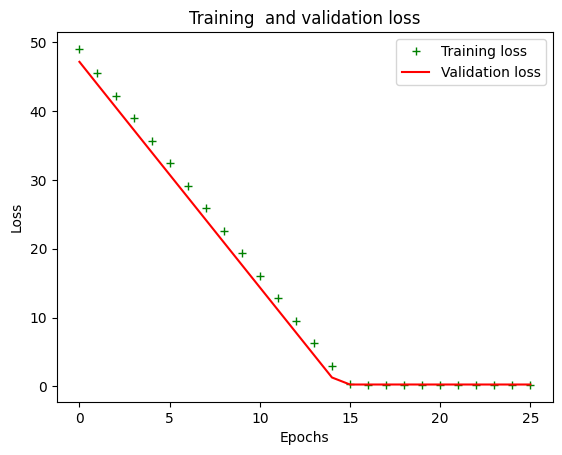

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, 'g+', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training  and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
prediction_train=model.predict(train_X)
prediction_train.shape

1044/1044 [==============================] - 11s 10ms/step


(33381, 1)

In [24]:
prediction_test=model.predict(test_X)
prediction_test.shape

261/261 [==============================] - 2s 8ms/step


(8328, 1)

In [25]:
from keras.layers import concatenate
print(test_data.shape)
test1=test_data[24:,:]
print(test1.shape)
print(type(test1),type(prediction_test))
pri1=concatenate((prediction_test,test1),axis=1)

(8352, 1)
(8328, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [26]:
rescaled_prediction = scaler.inverse_transform(pri1)
print('rescaled_prediction shape', rescaled_prediction.shape)
#print(rescaled_prediction[-5:,0])
#print(rescaled_prediction[:,0])
rescaled_prediction_pollution=rescaled_prediction[:len(test_X),0]
print(rescaled_prediction_pollution.shape)
test_data_actual_scale=scaler.inverse_transform(test_data)
print('test_data_actual_scale shape', test_data_actual_scale.shape)
test_data_actual_pollution=test_data_actual_scale[22:len(test_X)+22,0]
#test_data_actual_pollution=test_data_actual_scale[0:30,0]
print(test_data_actual_pollution.shape)

rescaled_prediction shape (8328, 2)
(8328,)
test_data_actual_scale shape (8352, 1)
(8328,)


In [27]:
rescaled_prediction_pollution.shape

(8328,)

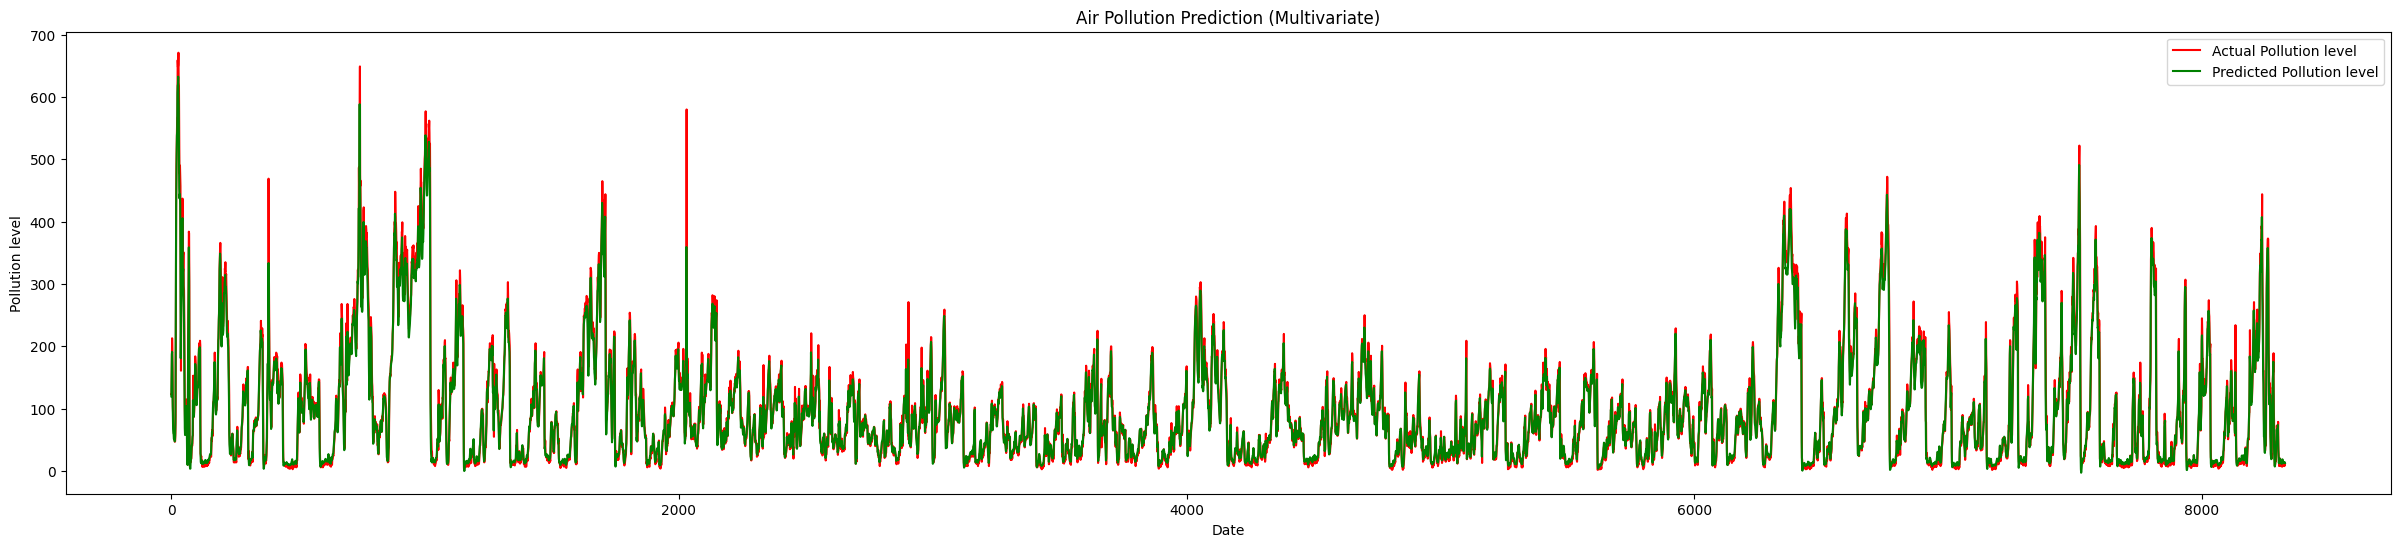

In [28]:
plt.figure(figsize=(30,6))  
plt.plot(test_data_actual_pollution , color = 'red', label = 'Actual Pollution level')
plt.plot(rescaled_prediction_pollution, color= 'green', label = 'Predicted Pollution level')

plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(rescaled_prediction_pollution,test_data_actual_pollution))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.475


In [30]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAE: %.3f' % mae)

Test MAE: 9.952


In [31]:
from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAPE: %.3f' % mape)

Test MAPE: 0.187


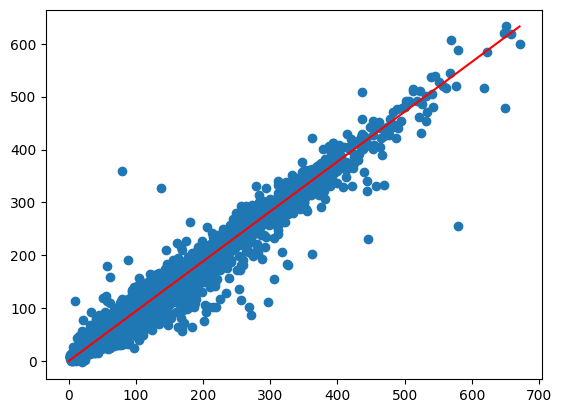

In [32]:
df1=pd.DataFrame()
df1['actual'] = pd.DataFrame(test_data_actual_pollution)
df1['predicted']=pd.DataFrame(rescaled_prediction_pollution)
plt.scatter(df1['actual'],df1['predicted'])
plt.plot([0,df1['actual'].max()],[0,df1['predicted'].max()],color='red')

# train

In [33]:
from keras.layers import concatenate
print(train_data.shape)
train1=train_data[24:,:]
print(train1.shape)
print(type(train1),type(prediction_train))
pri1=concatenate((prediction_train,train1),axis=1)

(33405, 1)
(33381, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [34]:
rescaled_prediction = scaler.inverse_transform(pri1)
print('rescaled_prediction shape', rescaled_prediction.shape)
#print(rescaled_prediction[-5:,0])
#print(rescaled_prediction[:,0])
rescaled_prediction_pollution=rescaled_prediction[:len(train_X),0]
print(rescaled_prediction_pollution.shape)
train_data_actual_scale=scaler.inverse_transform(train_data)
print('train_data_actual_scale shape', train_data_actual_scale.shape)
train_data_actual_pollution=train_data_actual_scale[22:len(train_X)+22,0]
#train_data_actual_pollution=train_data_actual_scale[0:30,0]
print(train_data_actual_pollution.shape)

rescaled_prediction shape (33381, 2)
(33381,)
train_data_actual_scale shape (33405, 1)
(33381,)


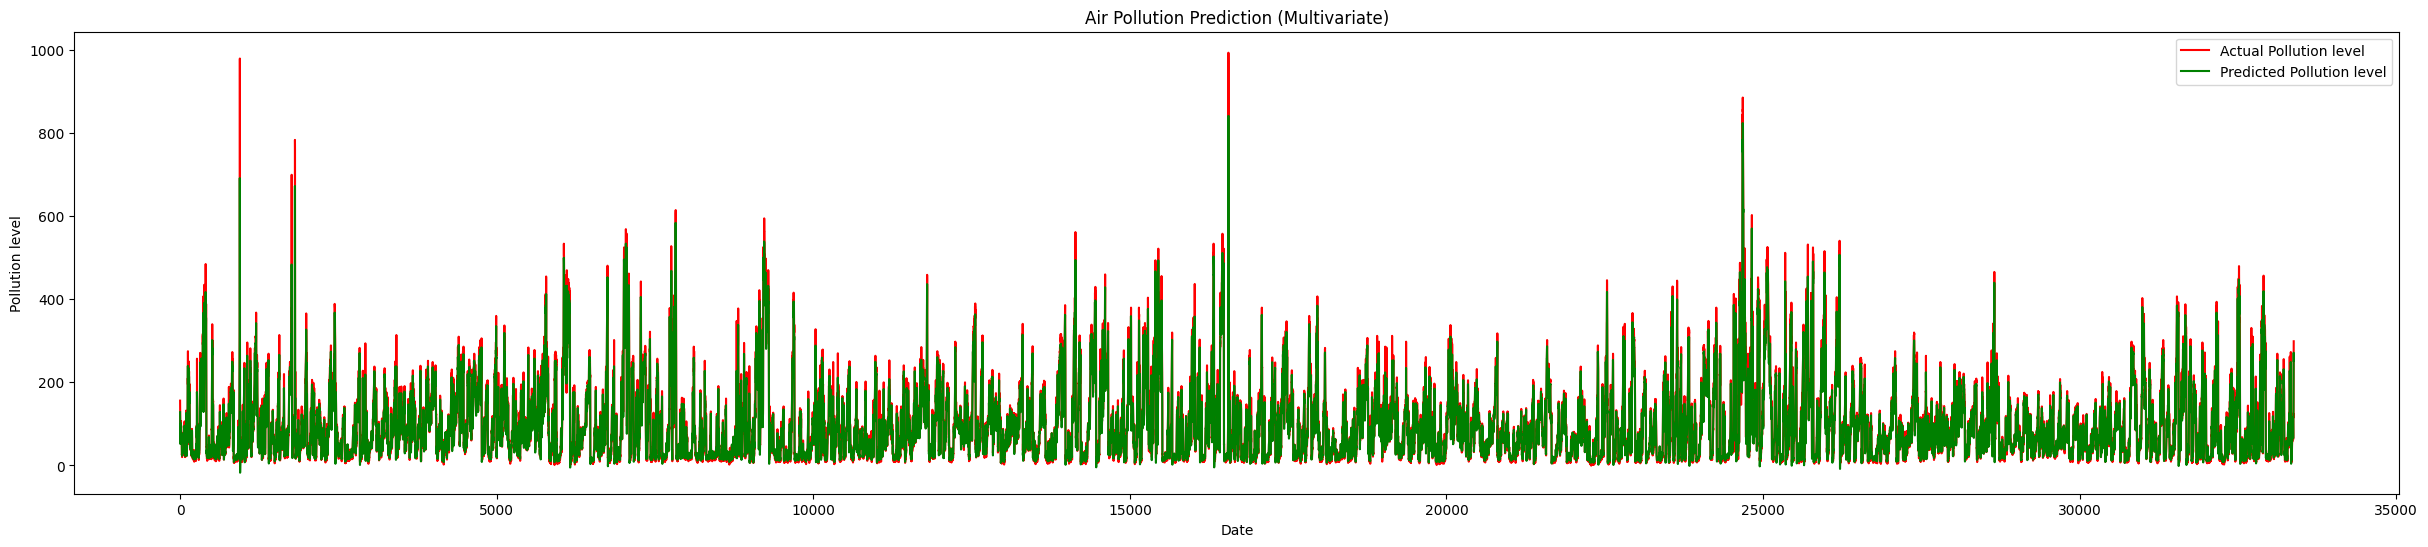

In [35]:
plt.figure(figsize=(30,6))  
plt.plot(train_data_actual_pollution , color = 'red', label = 'Actual Pollution level')
plt.plot(rescaled_prediction_pollution, color= 'green', label = 'Predicted Pollution level')

plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()

In [36]:
rmse = sqrt(mean_squared_error(rescaled_prediction_pollution,train_data_actual_pollution))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 19.255


In [37]:
mae=mean_absolute_error(train_data_actual_pollution,rescaled_prediction_pollution)
print('Train MAE: %.3f' % mae)

Train MAE: 10.768


In [38]:
mape=mean_absolute_percentage_error(train_data_actual_pollution,rescaled_prediction_pollution)
print('Train MAPE: %.3f' % mape)

Train MAPE: 2097789031610.415


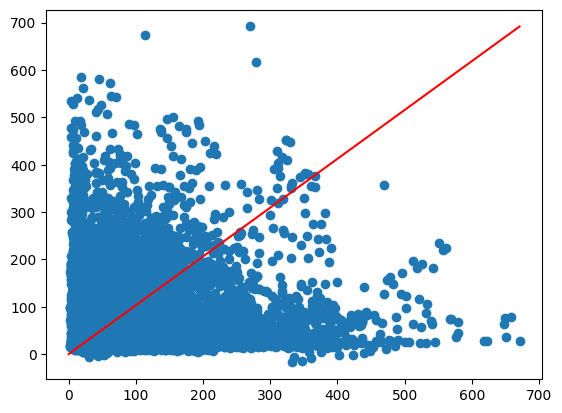

In [39]:
df1=pd.DataFrame()
df1['actual'] = pd.DataFrame(test_data_actual_pollution)
df1['predicted']=pd.DataFrame(rescaled_prediction_pollution)
plt.scatter(df1['actual'],df1['predicted'])
plt.plot([0,df1['actual'].max()],[0,df1['predicted'].max()],color='red')